In [1]:
import requests
import pandas as pd
import json

import sklearn


from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import psycopg2
from sqlalchemy import create_engine 
from dask.diagnostics import ProgressBar
import dask.dataframe as dd
import dask.array as da
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
from nltk.stem import WordNetLemmatizer
import re
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
#stop_words = set(stopwords.words('english'))
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline


import tensorflow as tf
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

# Problem Statement

Can you predict the type of the complaint based on the given variables?

# Objective

The goal here is to understand what factors contribute most to Complaint Type and create a model that can predict if a certain it. Need to analysis of Independent Variables and then model the algorithm

# Pipeline

1. Clean Data

2. Exploring the data will follow right after and allow further insight of what our dataset contains. 

3. Understanding the relationship each explanatory variable has with the response variable resides here and we can do this with a correlation matrix.

4. Modeling the data will give us our prediction of categorical variable COMPLAINT TYPE

In [2]:
df = pd.read_csv("C:\\EZOIC_ASSESSMENT\\Manhattan_new.csv",error_bad_lines=False)

In [3]:
df.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Park Facility Name,Park Borough,Latitude,Longitude,Location,Total_Time,Resolution_Time,Year,Month,DayofWeek
0,27842693,2014-04-14 00:00:00,2014-04-22 00:00:00,DOHMH,Department of Health and Mental Hygiene,rodent,rat sight,3 family apt building,10162,500 EAST 77 STREET,...,Unspecified,MANHATTAN,40.769974,-73.951186,"(40.769974489179866, -73.95118592429507)",8.0,8.0,2014,4,0
1,27842714,2014-04-14 08:59:00,2014-04-14 12:00:00,DSNY,Manhattan 01,SanitationComplaints,street conddumpoutdropoff,street,10013,91 FRANKLIN STREET,...,Unspecified,MANHATTAN,40.718098,-74.004964,"(40.718097970057514, -74.0049638254782)",0.0,0.0,2014,4,0
2,27842726,2014-04-14 07:09:00,2014-04-14 12:00:00,DSNY,Manhattan 02,SanitationComplaints,street conddumpoutdropoff,street,10011,78 5 AVENUE,...,Unspecified,MANHATTAN,40.735711,-73.993840,"(40.73571101507024, -73.99384048701876)",0.0,0.0,2014,4,0
3,27842813,2014-04-14 00:00:00,2014-04-23 00:00:00,HPD,Department of Housing Preservation and Develop...,Other Complaints,mold,RESIDENTIAL,10026,314 WEST 115 STREET,...,Unspecified,MANHATTAN,40.803954,-73.956380,"(40.803953620795205, -73.95638046816835)",9.0,9.0,2014,4,0
4,27842816,2014-04-14 00:00:00,2014-05-01 00:00:00,HPD,Department of Housing Preservation and Develop...,Other Complaints,refriger,RESIDENTIAL,10011,249 WEST 21 STREET,...,Unspecified,MANHATTAN,40.743407,-73.997975,"(40.74340744589288, -73.9979754622382)",17.0,17.0,2014,4,0


In [11]:
df["Resolution Description"]= df["Resolution Description"].astype(str) 
df["Descriptor"]= df["Descriptor"].astype(str) 
df["Agency"]= df["Agency"].astype(str) 
df["Complaint Type"]= df["Complaint Type"].astype(str) 
df["City"]= df["City"].astype(str) 

###########################################################################################################################
#################################################################################################################################################

## MULTI CLASS CLASSIFICATION  

----> Example : A fruit is ORANGE ,APPLE OR PEAR but not both or all three

1. As it is a classification task with more than 2 classes and "IMBALANCED DATASET" 
2. (Classification classess are not of same quanitiy)
3. I want to use LOGISTIC REGRESSION / KERAS/ CSR MATRIX CROSS VALIDATION
 

In [12]:
df_model = df[["Agency","Descriptor","Complaint Type","Location Type","City","Status","Resolution Description","Latitude","Longitude","Total_Time","Resolution_Time","Year","Month","DayofWeek"]]

In [13]:
df_model.dropna(how='any')

,Agency,Descriptor,Complaint Type,Location Type,City,Status,Resolution Description,Latitude,Longitude,Total_Time,Resolution_Time,Year,Month,DayofWeek
0,DOHMH,rat sight,rodent,3 family apt building,New York,Closed,department health mental hygiene review compla...,40.769974,-73.951186,8.0,8.0,2014,4,0
1,DSNY,street conddumpoutdropoff,SanitationComplaints,street,New York,Closed,department sanitation investigated complaint f...,40.718098,-74.004964,0.0,0.0,2014,4,0
2,DSNY,street conddumpoutdropoff,SanitationComplaints,street,New York,Closed,department sanitation investigated complaint f...,40.735711,-73.993840,0.0,0.0,2014,4,0
3,HPD,mold,Other Complaints,RESIDENTIAL,New York,Closed,department housing preservation development ab...,40.803954,-73.956380,9.0,9.0,2014,4,0
4,HPD,refriger,Other Complaints,RESIDENTIAL,New York,Closed,department housing preservation development ab...,40.743407,-73.997975,17.0,17.0,2014,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2889293,HPD,wall,Paint/PlasterComplaints,RESIDENTIAL,New York,Closed,department housing preservation development in...,40.838192,-73.945014,22.0,22.0,2014,4,0
2889294,HPD,wall,Paint/PlasterComplaints,RESIDENTIAL,New York,Closed,department housing preservation development ab...,40.836272,-73.943274,21.0,21.0,2014,4,0
2889295,DSNY,graffiti,StreetComplaints,COMMERCIAL,New York,Closed,city removed graffiti properti,40.718532,-74.002305,133.0,137.0,2014,4,0
2889296,DOHMH,building found,WaterComplaints,other,New York,Closed,department health mental hygiene review servic...,40.808079,-73.950237,23.0,23.0,2014,4,0


In [14]:
df_model.shape

(2889298, 14)

## Label Powerset

In [15]:
df_model.dtypes

Agency                     object
Descriptor                 object
Complaint Type             object
Location Type              object
City                       object
Status                     object
Resolution Description     object
Latitude                  float64
Longitude                 float64
Total_Time                float64
Resolution_Time           float64
Year                        int64
Month                       int64
DayofWeek                   int64
dtype: object

In [16]:
df_model_label = df_model.copy()

In [17]:
label_encoder = LabelEncoder()
df_model_label['Agency']=label_encoder.fit_transform(df_model['Agency'])
df_model_label['Descriptor']=label_encoder.fit_transform(df_model['Descriptor'])
df_model_label['City']=label_encoder.fit_transform(df_model['City'])
df_model_label['Status']=label_encoder.fit_transform(df_model['Status'])
df_model_label['Resolution Description']=label_encoder.fit_transform(df_model['Resolution Description'])
df_model_label['Complaint Type']=label_encoder.fit_transform(df_model['Complaint Type'])
df_model_label['Location Type']=label_encoder.fit_transform(df_model['Location Type'])

In [18]:
df_model_label.head()

,Agency,Descriptor,Complaint Type,Location Type,City,Status,Resolution Description,Latitude,Longitude,Total_Time,Resolution_Time,Year,Month,DayofWeek
0,7,436,24,4,7,1,218,40.769974,-73.951186,8.0,8.0,2014,4,0
1,11,11,10,95,7,1,352,40.718098,-74.004964,0.0,0.0,2014,4,0
2,11,11,10,95,7,1,352,40.735711,-73.993840,0.0,0.0,2014,4,0
3,13,359,7,8,7,1,265,40.803954,-73.956380,9.0,9.0,2014,4,0
4,13,439,7,8,7,1,265,40.743407,-73.997975,17.0,17.0,2014,4,0


## Feature Engineering

1. Correlation is from 0 to 1 where 0 indicates least correlation and 1 indicates highest

### Correlation

,Agency,Descriptor,Complaint Type,Location Type,City,Status,Resolution Description,Latitude,Longitude,Total_Time,Resolution_Time,Year,Month,DayofWeek
Agency,1.000000,-0.082729,-0.335364,-0.176717,0.004395,0.003187,0.316354,0.178746,0.185890,-0.039490,-0.045917,0.013877,0.003653,0.089980
Descriptor,-0.082729,1.000000,0.097142,-0.083878,-0.001352,0.005023,0.012976,0.013235,0.008329,0.019696,0.022848,-0.062041,0.014025,0.008121
Complaint Type,-0.335364,0.097142,1.000000,0.303860,-0.003405,0.000043,-0.087709,-0.183486,-0.180634,0.067853,0.079882,-0.037928,0.006141,-0.055653
Location Type,-0.176717,-0.083878,0.303860,1.000000,-0.003236,-0.008508,0.259874,-0.245940,-0.256537,0.022756,0.027638,0.008119,0.020425,-0.003908
City,0.004395,-0.001352,-0.003405,-0.003236,1.000000,0.000265,-0.000333,-0.012787,-0.013573,0.000832,0.000993,0.005028,0.002126,-0.000115
Status,0.003187,0.005023,0.000043,-0.008508,0.000265,1.000000,-0.005157,0.007566,0.007347,0.001897,-0.003879,-0.021310,-0.001082,-0.002188
Resolution Description,0.316354,0.012976,-0.087709,0.259874,-0.000333,-0.005157,1.000000,-0.065085,-0.061553,-0.092719,-0.111080,0.057377,0.025214,0.160475
Latitude,0.178746,0.013235,-0.183486,-0.245940,-0.012787,0.007566,-0.065085,1.000000,0.914678,-0.022347,-0.026830,0.017864,-0.005914,0.015777
Longitude,0.185890,0.008329,-0.180634,-0.256537,-0.013573,0.007347,-0.061553,0.914678,1.000000,-0.021464,-0.025760,0.017410,-0.008409,0.015794
Total_Time,-0.039490,0.019696,0.067853,0.022756,0.000832,0.001897,-0.092719,-0.022347,-0.021464,1.000000,0.833756,-0.040323,0.002823,-0.028886


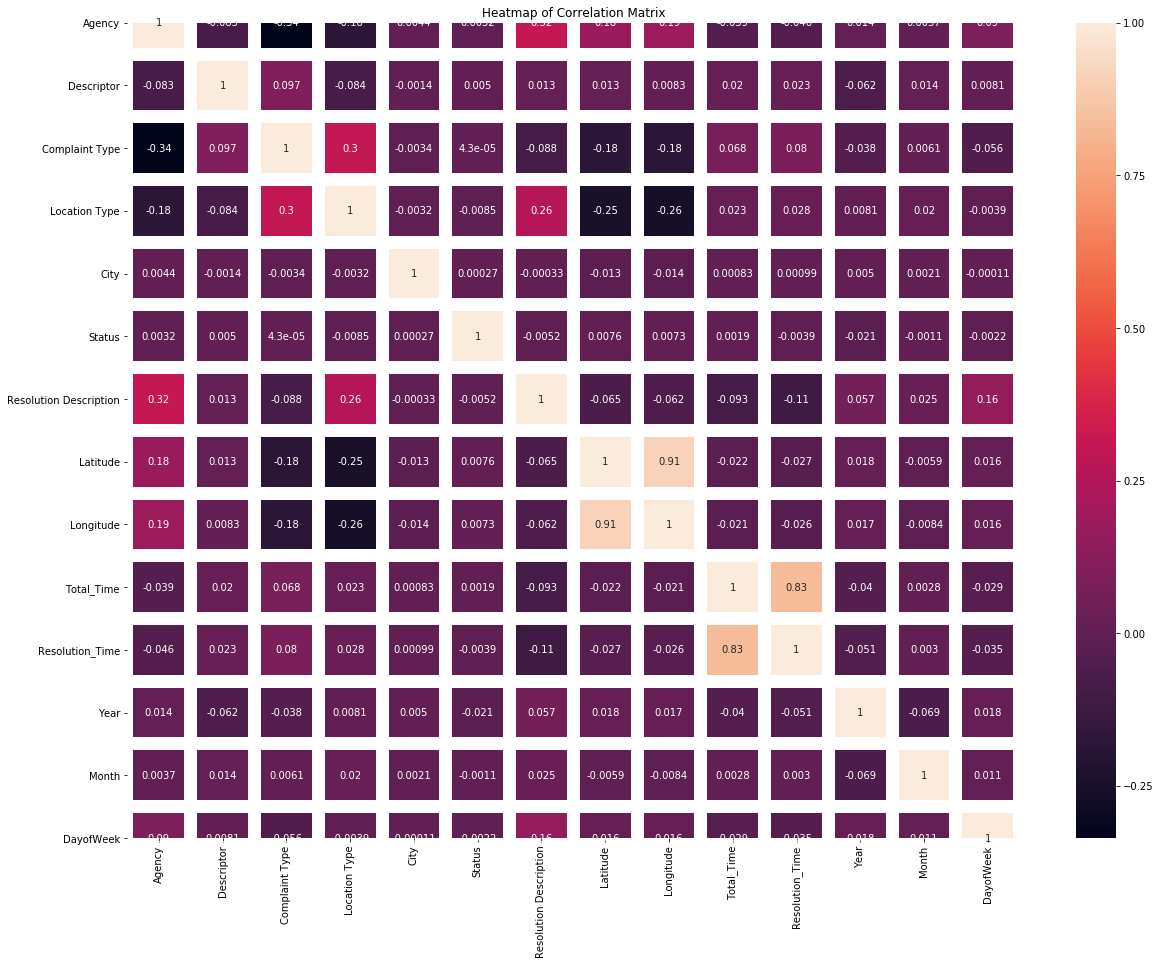

In [19]:
corr = df_model_label.corr()
fig, ax = plt.subplots(figsize=(20,15))    
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            linewidths=12, 
            ax=ax,
            annot=True, 
            annot_kws={"size": 10})
plt.title('Heatmap of Correlation Matrix')
corr

In [24]:
X = df_model_label[["Agency","Descriptor","Location Type","City","Status","Resolution Description","Total_Time","Resolution_Time","Year","Month","DayofWeek"]]
y = df_model_label["Complaint Type"]

1. Complaint Type is correlated to Location Type
2. Resolution Description and Agency are correlated

X = df_model[["Agency","Descriptor","Location","City","Status","Resolution Description","Latitude","Longitude","Total_Time","Resolution_Time","Year","Month","DayofWeek"]]
y = df_model["Complaint Type"]

train_img, test_img, train_lbl, test_lbl = train_test_split(X, y, test_size=1/7.0, random_state=122)

### Feature Importance and Selection

### Univariate Selection

In [25]:
# apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=5)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#For classification: chi2, f_classif, mutual_info_classif
# concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  # naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 5 best features

                     Specs         Score
5   Resolution Description  1.904833e+08
2            Location Type  7.219580e+07
7          Resolution_Time  5.513623e+07
6               Total_Time  5.434763e+07
1               Descriptor  4.048888e+07
0                   Agency  9.666111e+05
10               DayofWeek  2.114072e+05
9                    Month  1.266545e+04
8                     Year  1.125424e+03
4                   Status  2.584667e+01


1. SKLearn selects best features suitable to our target variable
2. Its a chi2 test for non negative features

### Feature Importance

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

clf=RandomForestClassifier(n_estimators=100)

clf.fit(X_train,y_train)
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

Descriptor                0.415832
Agency                    0.161271
Resolution Description    0.143784
Location Type             0.099468
Total_Time                0.063991
Resolution_Time           0.055722
Year                      0.035998
Month                     0.013716
DayofWeek                 0.010101
Status                    0.000096
City                      0.000021
dtype: float64

No handles with labels found to put in legend.


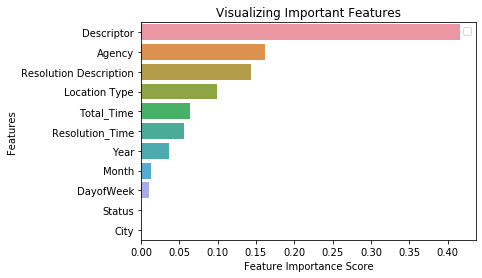

In [27]:
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

### Baseline Model : Logistic Regression

In [28]:
train_img, test_img, train_lbl, test_lbl = train_test_split(X, y, test_size=1/7.0, random_state=122)
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(train_img)
# Apply transform to both the training set and the test set.
train_img = scaler.transform(train_img)
test_img = scaler.transform(test_img)

In [29]:
model = LogisticRegression(solver = 'lbfgs')
model.fit(train_img, train_lbl)

C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
import sklearn.metrics as metrics
# use the model to make predictions with the test data
y_pred = model.predict(test_img)
# how did our model perform?
count_misclassified = (test_lbl != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(test_lbl, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))

Misclassified samples: 166747
Accuracy: 0.60


####### the above gives the misclassifed samples 
##### Evaluate the model thru Confusion Matrix but here its multi class so hard to understand but lets calculate precision and accuracy

In [31]:
cnf_matrix = metrics.confusion_matrix(test_lbl, y_pred)
cnf_matrix

array([[   654,   2017,      0,   3891,      0,      0,     40,   3488,
           465,      0,      0,      0,      5,      0,      0,      0,
             0,      0,      0,      0,      3,      0,      0,      8,
             0],
       [   695,  12007,      0,   7899,      0,      0,    131,   2159,
           397,      0,      0,      0,      4,      0,      0,      0,
             0,      0,      0,      0,    111,      0,     17,     16,
             0],
       [     0,      0,    108,      0,      0,     58,      0,     17,
             0,      0,      0,      0,     38,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,     16,
             1],
       [     0,    180,      0,  49045,      0,      0,  10113,     95,
             0,      0,      0,      0,      2,      0,      0,      0,
             0,      0,      0,      0,      6,      0,      0,      0,
             0],
       [     0,      0,      0,      6,     19,     22,      9,    3

We have to take accuracy into consideration as it is very less for our baseline model lets try with random forest classifer as tree based modelsa are robust and works well for classification

In [119]:
np.diag(cnf_matrix)

array([  1452,  12218,     91,  49057,     19,   8834, 112994,   1840,
         1084,   5961,    291,      1,  25117,   6970,      0,      0,
         2399,     60,      0,      0,    429,      8,      1,   3555,
         5039], dtype=int64)

In [120]:
np.sum(cnf_matrix, axis = 0)

array([  9791,  37504,    122,  83431,     23,  10122, 156146,   4851,
         4009,   9557,   4750,      8,  61249,   9193,      4,     90,
         4723,     60,      0,    127,   1220,     32,     19,   5515,
        10211], dtype=int64)

In [32]:
recall = np.mean(np.diag(cnf_matrix) / np.sum(cnf_matrix, axis = 1))

In [122]:
(np.diag(cnf_matrix) / np.sum(cnf_matrix, axis = 0))

C:\Users\pavani.nrusimhadevar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([0.14829946, 0.32577858, 0.74590164, 0.58799487, 0.82608696,
       0.87275242, 0.72364326, 0.37930324, 0.27039162, 0.6237313 ,
       0.06126316, 0.125     , 0.41008016, 0.75818558, 0.        ,
       0.        , 0.50793987, 1.        ,        nan, 0.        ,
       0.35163934, 0.25      , 0.05263158, 0.64460562, 0.49348742])

In [33]:
precision = np.mean(np.diag(cnf_matrix) / np.sum(cnf_matrix, axis = 0))

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [34]:
print("precision",precision)
print("recall",recall)

precision nan
recall 0.3366780121860723


Accuracy is the main metric for multi class classification as precision and recall scores doesnt play an important role as we are taking aaverage of individual classes (Each complaint Type)

### Random Forests Classification

My favourite is tree based models as they work faster and works well with classification 
Its used to identify feature importance too

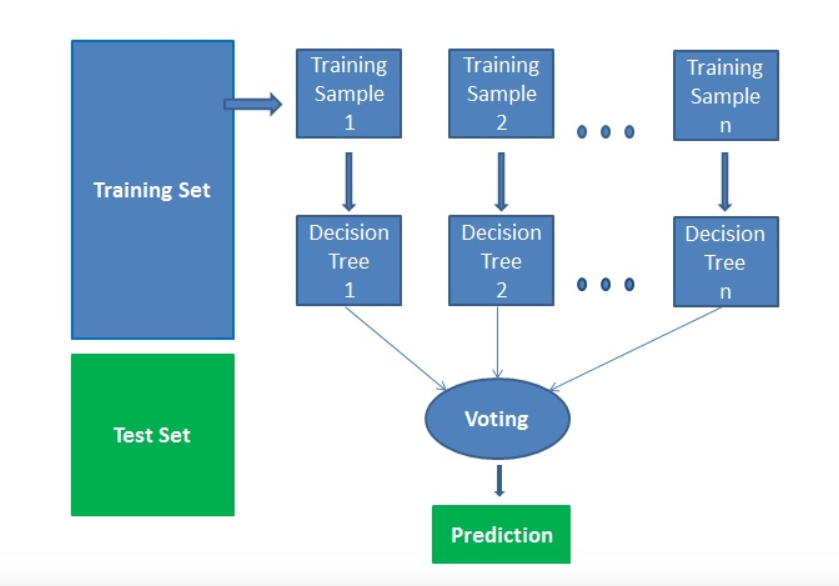

In [125]:
from IPython.display import Image
Image(filename='rf.png')

In [35]:
X = df_model_label[["Agency","Descriptor","Location Type","City","Status","Resolution Description","Total_Time","Resolution_Time","Year","Month","DayofWeek"]]
y = df_model_label["Complaint Type"]

In [36]:
clf=RandomForestClassifier(n_estimators=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.989678007360491


In [37]:
count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))

Misclassified samples: 8947


#### Checking if my model is overfitting --- 10 Fold CV

In [38]:
scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
print(scores)

[0.93029767 0.91719763 0.94871892 0.94623358 0.9588584  0.899684
 0.91104958 0.92858972 0.94140959 0.88352404]


My number of missclassifed samples are extremely less and thats why accuracy score went up which is good

Ideas!!

How  about holidays and Season? Does these complaints go up or what kind of complaints can be expected


## Season

In [39]:
conditions =[
    (df['Month']==1 )| (df['Month']==12)| (df['Month']==2),
    (df['Month']==3) | (df['Month']==4) | ( df['Month']==5),
    (df['Month']==6) | (df['Month']==7) | (df['Month']==8),
    (df['Month']==9)|(df['Month']==10)| (df['Month']==11),
   ]
choices = ['Winter', 'Spring', 'Summer','Fall']
df['Season']= np.select(conditions, choices, default="black")

In [40]:
df_model = df[["Agency","Descriptor","Complaint Type","Season","Location Type","City","Status","Resolution Description","Latitude","Longitude","Total_Time","Resolution_Time","Year","Month","DayofWeek"]]

In [41]:

label_encoder = LabelEncoder()
df_model['Agency.']=label_encoder.fit_transform(df_model['Agency'])
df_model['Descriptor.']=label_encoder.fit_transform(df_model['Descriptor'])
df_model['City.']=label_encoder.fit_transform(df_model['City'])
df_model['Status.']=label_encoder.fit_transform(df_model['Status'])
df_model['Resolution Description.']=label_encoder.fit_transform(df_model['Resolution Description'])
df_model['Complaint Type.']=label_encoder.fit_transform(df_model['Complaint Type'])
df_model['Location Type.']=label_encoder.fit_transform(df_model['Location Type'])
df_model['Season.']=label_encoder.fit_transform(df_model['Season'])

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

No handles with labels found to put in legend.


Descriptor.                0.413698
Agency.                    0.156061
Resolution Description.    0.129701
Location Type.             0.094811
Total_Time                 0.076683
Resolution_Time            0.064008
Year                       0.038130
DayofWeek                  0.012412
Month                      0.009589
Season.                    0.004768
Status.                    0.000115
City.                      0.000025
dtype: float64


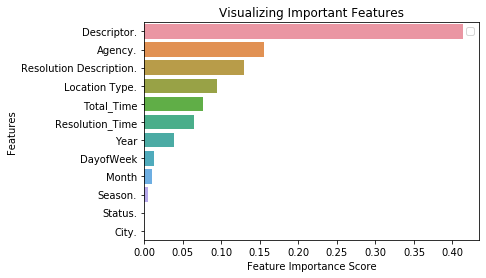

In [42]:
X = df_model[["Agency.","Descriptor.","Location Type.","City.","Status.","Resolution Description.","Season.","Total_Time","Resolution_Time","Year","Month","DayofWeek"]]
y = df_model["Complaint Type."]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

clf=RandomForestClassifier(n_estimators=100)

clf.fit(X_train,y_train)
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
print(feature_imp)

sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

Complaints are not dependendant much on Season which makes sense unless you are evaluating specific type of complaintts

Ex: During Christmas we can expect people ordering xmas trees and keeping those large trees on sidewalks
    or
    Water problems in houses during winter liek breaking of pipes due of very cold weathers in NY

In [43]:
X = df_model[["Agency.","Descriptor.","Location Type.","City.","Status.","Resolution Description.","Season.","Total_Time","Resolution_Time","Year","Month","DayofWeek"]]
y = df_model["Complaint Type."]
clf=RandomForestClassifier(n_estimators=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9882589785299785


In [44]:
print(metrics.confusion_matrix(y_test, y_pred))

[[ 21814     49      0      1      0      0      0    272      5      0
       0      0      0      0      0     43      0      0     64      0
      36      0      0      0      0]
 [     8  48893      0      3      0      0      0    103     73      0
       0      0      0      0      0      3      0      0     28      0
     132      0    157      0      1]
 [     0      0    520      0      0      0      0      3      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [     1     12      0 124027      0      0      0     49      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      2      0      0]
 [     0      0      0      0    927      0      0      4      0      0
       0      0      4      0      0      0      0      0      0      0
       0      0      0      0      0]
 [     0      0      0      0      0  26001      1    867      0      0
       0      0   

In [45]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     22284
           1       0.98      0.99      0.98     49401
           2       1.00      0.99      1.00       523
           3       1.00      1.00      1.00    124091
           4       1.00      0.99      0.99       935
           5       0.95      0.97      0.96     26869
           6       1.00      1.00      1.00    244919
           7       0.97      0.97      0.97     74650
           8       0.99      0.98      0.99     33969
           9       0.99      0.99      0.99     55727
          10       1.00      1.00      1.00     22373
          11       1.00      0.99      0.99       515
          12       0.99      0.98      0.99     77485
          13       0.93      0.96      0.94     15636
          14       0.98      0.93      0.95      4100
          15       0.99      0.99      0.99     11793
          16       0.98      0.99      0.99     27741
          17       1.00    

### The model need to have HIGH precision and HIGH Accuracy so our model is a good one

#### If we can we can try other models too 

But Random forests or tree based models in general are always good for any classification techniques but we can check

#### Trying KNN

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3) # 70% training and 30% test


#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test,y_pred))

Accuracy: 0.9820890873221888
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     22195
           1       0.97      0.97      0.97     49580
           2       0.98      1.00      0.99       486
           3       1.00      1.00      1.00    124677
           4       0.98      0.98      0.98       953
           5       0.93      0.97      0.95     27028
           6       1.00      1.00      1.00    245605
           7       0.96      0.92      0.94     47995
           8       0.97      0.97      0.97     33811
           9       0.99      0.98      0.99     55146
          10       0.98      0.99      0.98     48945
          11       0.97      0.98      0.97       519
          12       0.98      0.97      0.98     77352
          13       0.91      0.95      0.93     15431
          14       0.99      0.98      0.98      4128
          15       0.96      0.99      0.98     11901
          16       0.97      0.99      0.98     2738

In [112]:
df.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Park Facility Name,Park Borough,Latitude,Longitude,Location,Total_Time,Resolution_Time,Year,Month,DayofWeek
0,27842670,2014-04-14 08:16:00,2014-04-24 11:15:00,DEP,Department of Environmental Protection,Water System,Hydrant Knocked Over/Missing (WC),NaN,10017,270 PARK AVENUE,...,Unspecified,MANHATTAN,40.755641,-73.975109,"(40.75564086047822, -73.97510913260558)",10.0,10.0,2014,4,0
1,27842682,2014-04-14 11:38:00,2014-04-15 03:45:00,DEP,Department of Environmental Protection,Water System,No Water/Low Pressure (WA5),NaN,10009,278 EAST 10 STREET,...,Unspecified,MANHATTAN,40.728225,-73.983158,"(40.72822500217204, -73.98315795150333)",0.0,0.0,2014,4,0
2,27842683,2014-04-14 15:13:00,2014-04-21 12:00:00,DEP,Department of Environmental Protection,Air Quality,"Air: Smoke, Vehicular (AA4)",NaN,10003,101 EAST 16 STREET,...,Unspecified,MANHATTAN,40.735867,-73.989153,"(40.73586711990034, -73.98915316963569)",6.0,6.0,2014,4,0
3,27842693,2014-04-14 00:00:00,2014-04-22 00:00:00,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,3+ Family Apt. Building,10162,500 EAST 77 STREET,...,Unspecified,MANHATTAN,40.769974,-73.951186,"(40.769974489179866, -73.95118592429507)",8.0,8.0,2014,4,0
4,27842714,2014-04-14 08:59:00,2014-04-14 12:00:00,DSNY,Manhattan 01,Sanitation Condition,15 Street Cond/Dump-Out/Drop-Off,Street,10013,91 FRANKLIN STREET,...,Unspecified,MANHATTAN,40.718098,-74.004964,"(40.718097970057514, -74.0049638254782)",0.0,0.0,2014,4,0


##### TF IDF

#df_model_model_loctype = df_model[["Agency","Location","Location Type","City","Incident Zip","Latitude","Longitude"]]
# CountVectorizer - Simply, counts word frequencies 
# TFIdf_model - More importance/weights on "rare" words. Less importance/weights on "frequent" words
from sklearn.feature_extraction.text import CountVectorizer, Tfidf_modelVectorizer
# LabelBinarizer - Converts labels into numerical representation "G,B,R" -> [1,2,3]
from sklearn.preprocessing import LabelBinarizer
from scipy.sparse import vstack, hstack, csr_matrix

## APPLYING COUNT VECTORIZATION THAT CONVERTS IT INTO A SPARSE AMTRIX

cv = CountVectorizer(min_df_model=10)
X_ResDes = cv.fit_transform(df_model['Resolution Description'])
X_ResDes

##############################################################################################

#cv = CountVectorizer()
#X_LocType = cv.fit_transform(df_model['Location Type'])
#X_LocType
#################################################################################################

## TF Idf_model Vectorization ----> More importance is given to rare words
## Count Vectorizor --> Gives the frequencies of Words
## Label Binarizer --> Coverts G,B,R --> 1,2,3

################################################################################################

cv = CountVectorizer()
X_Des = cv.fit_transform(df_model['Descriptor'])
#X_sub1 = cv.fit_transform(combined['sub_category_1'])
#X_sub2 = cv.fit_transform(combined['sub_category_2'])
X_Des

###############################################################################################

# Apply TFIdf_model to "resolution_description", 
tv = Tfidf_modelVectorizer(max_features=55000, ngram_range=(1, 2), stop_words='english')
X_description = tv.fit_transform(df_model['Resolution Description'])

tv = Tfidf_modelVectorizer(max_features=55000, ngram_range=(1, 2), stop_words='english')
X_descriptor = tv.fit_transform(df_model['Descriptor'])

# Apply LabelBinarizer to "Location Type"
lb = LabelBinarizer(sparse_output=True)
X_Loc = lb.fit_transform(df_model['Location Type'])

# Apply LabelBinarizer to "Location Type"
lb = LabelBinarizer(sparse_output=True)
X_Com = lb.fit_transform(df_model['Complaint Type'])

#####################################################################################################

####### Creating CSR Matrix

####### Merging the Sparse Matrices

# Create our final sparse matrix
X_dummies = csr_matrix(pd.get_dummies(df_model[['Agency','City', 'Status','Latitude',
                                                'Longitude','Total_Time','Resolution_Time',
                                                'Year','Month','DayofWeek']], sparse=True).values)

# Combine everything together
sparse_merge = hstack((X_dummies, X_description, X_descriptor, X_Loc,X_Com)).tocsr()

####################################################################################################

X_train = sparse_merge[:len(df)]

y = sparse_merge[len(df):]

from sklearn.model_selection import KFold
eval_size = .10
kf = KFold(10,shuffle=False)
i = 0
for train_indicies, valid_indicies in kf.split(X_train,y):
    print("TRAIN:", train_indices, "TEST:", test_indices)
    X_train, y_train = X_train[train_indicies], y[train_indicies]
    X_valid, y_valid = X_train[valid_indicies], y[valid_indicies]
    i = i+1


In [46]:
### Multi Class Text Classification

In [47]:
df2 = pd.read_csv("C:\\EZOIC_ASSESSMENT\\Manhattan_new.csv",error_bad_lines=False)

In [48]:
df1 = df2.head(60000)

In [49]:
df1.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Park Facility Name,Park Borough,Latitude,Longitude,Location,Total_Time,Resolution_Time,Year,Month,DayofWeek
0,27842693,2014-04-14 00:00:00,2014-04-22 00:00:00,DOHMH,Department of Health and Mental Hygiene,rodent,rat sight,3 family apt building,10162,500 EAST 77 STREET,...,Unspecified,MANHATTAN,40.769974,-73.951186,"(40.769974489179866, -73.95118592429507)",8.0,8.0,2014,4,0
1,27842714,2014-04-14 08:59:00,2014-04-14 12:00:00,DSNY,Manhattan 01,SanitationComplaints,street conddumpoutdropoff,street,10013,91 FRANKLIN STREET,...,Unspecified,MANHATTAN,40.718098,-74.004964,"(40.718097970057514, -74.0049638254782)",0.0,0.0,2014,4,0
2,27842726,2014-04-14 07:09:00,2014-04-14 12:00:00,DSNY,Manhattan 02,SanitationComplaints,street conddumpoutdropoff,street,10011,78 5 AVENUE,...,Unspecified,MANHATTAN,40.735711,-73.993840,"(40.73571101507024, -73.99384048701876)",0.0,0.0,2014,4,0
3,27842813,2014-04-14 00:00:00,2014-04-23 00:00:00,HPD,Department of Housing Preservation and Develop...,Other Complaints,mold,RESIDENTIAL,10026,314 WEST 115 STREET,...,Unspecified,MANHATTAN,40.803954,-73.956380,"(40.803953620795205, -73.95638046816835)",9.0,9.0,2014,4,0
4,27842816,2014-04-14 00:00:00,2014-05-01 00:00:00,HPD,Department of Housing Preservation and Develop...,Other Complaints,refriger,RESIDENTIAL,10011,249 WEST 21 STREET,...,Unspecified,MANHATTAN,40.743407,-73.997975,"(40.74340744589288, -73.9979754622382)",17.0,17.0,2014,4,0


In [64]:
X = df1['Resolution Description']
y = df1['Complaint Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [65]:
import pickle
# instead of doing these steps one at a time, we can use a pipeline to complete then all at once
pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2, k=900)),
                     ('clf', RandomForestClassifier())])

# fitting our model and save it in a pickle for later use
model = pipeline.fit(X_train, y_train)
with open('RandomForest.pickle', 'wb') as f:
    pickle.dump(model, f)

ytest = np.array(y_test)

# confusion matrix and classification report(precision, recall, F1-score)
print(classification_report(ytest, model.predict(X_test)))
print(confusion_matrix(ytest, model.predict(X_test)))

C:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                                 precision    recall  f1-score   support

             BuildingComplaints       0.00      0.00      0.00      2034
Construction/PlumbingComplaints       0.00      0.00      0.00      1446
                 HeatComplaints       0.91      0.86      0.88      2460
              HighwayComplaints       0.50      0.12      0.20         8
             HomelessComplaints       0.00      0.00      0.00         7
                NoiseComplaints       0.68      0.80      0.74        61
               Other Complaints       0.28      0.67      0.40      3479
        Paint/PlasterComplaints       0.28      0.42      0.33      2295
              ParkingComplaints       0.60      0.60      0.60        30
           SanitationComplaints       0.69      0.87      0.77      1286
                SewerComplaints       0.75      0.75      0.75         4
               StreetComplaints       0.98      0.84      0.90       615
                 TaxiComplaints       0.78      1.

In [66]:
print('accuracy %s' % accuracy_score(model.predict(X_test), ytest))

accuracy 0.47838888888888886


In [ ]:
### 